<a href="https://colab.research.google.com/github/kabirchhabra/Skillslash/blob/main/CapstoneProject/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Capstone Project**

+ Given eight columns, using which we must predict the strength of the cement.

**Mounting drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing necessary libraries**


In [2]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Data manipulation and handling libraries
import numpy as np
import pandas as pd

#Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import scipy.stats as sci

#Data preprocessing and EDA libraries
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

#Model selection libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#ML models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost
from xgboost import XGBRegressor

#Model evaluation
from sklearn.metrics import r2_score, mean_squared_error

#Warning filter library
import warnings
warnings.filterwarnings('ignore')

#Multi-collinearity test and treatment libraries
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
#Loading the dataframe
df = pd.read_csv('/content/drive/MyDrive/Skillslash/Projects/Capstone Project.csv')
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


**Exploratory Data Analysis**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Observations: 
+ There are no null values
+ There are 1030 records and 9 columns
+ Dependent variable = strength

In [6]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


Analysis from Descriptive Statistics:
+ There might be skewness in the data in all columns.
+ There might be chance of outliers if we compare quartile of some columns.
+ Since minimum and q1 values are same for slag and ash, so we do not have outliers in the lower whisker region.
+ The range of value 'age' is from 1-365. We can say that the values are in days.


In [7]:
def custom_summary(my_df):
  result = []
  for col in my_df.columns:
    if my_df[col].dtypes != 'object':
      stats = OrderedDict({
          'Feature_name' : col,
          'count' : my_df[col].count(),
          'quartile1' : my_df[col].quantile(.25),
          'quartile2' : my_df[col].quantile(.5),
          'quartile3' : my_df[col].quantile(.75),
          'mean' : my_df[col].mean(),
          'max' : my_df[col].max(),
          'variance' : round(my_df[col].var()),
          'standard_deviation' : my_df[col].std(),
          'skewness' : my_df[col].skew(),
          'kurtosis' : my_df[col].kurt()
      })

    result.append(stats)
  
  result_df = pd.DataFrame(result)

  #skewness type
  skewness_label = []
  for i in result_df['skewness']:
    if i <= -1:
      skewness_label.append('Highky negative skewed')
    elif -1 < i <= -0.5:
      skewness_label.append('Moderately negatively skewed')
    elif -0.5 < i < 0:
      skewness_label.append('Fairly negatively skewed')
    elif 0 <= i <=1:
      skewness_label.append('Fairly positive skewed')
    elif 0.5 <= i < 1:
      skewness_label.append('Moderately positive skewed')
    elif i>=1:
      skewness_label.append('Highly positive skewed')

  result_df['skewness_comment'] = skewness_label

  #kurtosis type:
  kurtosis_label = []
  for i in result_df['kurtosis']:
    if i >= 1:
      kurtosis_label.append('Leptokurtic Curve')
    elif i <= -1:
      kurtosis_label.append('Platykurtic Curve')
    else:
      kurtosis_label.append("Mesokurtic Curve")
  
  result_df['kurtosis_comment'] = kurtosis_label

  #Outliers
  outliers_label = []
  for col in my_df.columns:
    if my_df[col].dtypes != 'object':
      q1 = my_df[col].quantile(0.25)
      q2 = my_df[col].quantile(0.5)
      q3 = my_df[col].quantile(0.75)

      iqr = q3-q1
      lower_whisker = q1 - 0.25*iqr
      upper_whisker = q3 + 0.25*iqr

      if len(my_df[(my_df[col] < lower_whisker) | (my_df[col] > upper_whisker)]) > 0:
        outliers_label.append("Outliers present")  
      else:
        outliers_label.append("No outliers")

  result_df['outliers_comment'] = outliers_label

  return result_df

In [8]:
custom_summary(df)

,Feature_name,count,quartile1,quartile2,quartile3,mean,max,variance,standard_deviation,skewness,kurtosis,skewness_comment,kurtosis_comment,outliers_comment
0,cement,1030,192.375,272.900,350.000,281.167864,540.0,10922,104.506364,0.509481,-0.520652,Fairly positive skewed,Mesokurtic Curve,Outliers present
1,slag,1030,0.000,22.000,142.950,73.895825,359.4,7444,86.279342,0.800717,-0.508175,Fairly positive skewed,Mesokurtic Curve,Outliers present
2,ash,1030,0.000,0.000,118.300,54.188350,200.1,4096,63.997004,0.537354,-1.328746,Fairly positive skewed,Platykurtic Curve,Outliers present
3,water,1030,164.900,185.000,192.000,181.567282,247.0,456,21.354219,0.074628,0.122082,Fairly positive skewed,Mesokurtic Curve,Outliers present
4,superplastic,1030,0.000,6.400,10.200,6.204660,32.2,36,5.973841,0.907203,1.411269,Fairly positive skewed,Leptokurtic Curve,Outliers present
5,coarseagg,1030,932.000,968.000,1029.400,972.918932,1145.0,6046,77.753954,-0.040220,-0.599016,Fairly negatively skewed,Mesokurtic Curve,Outliers present
6,fineagg,1030,730.950,779.500,824.000,773.580485,992.6,6428,80.175980,-0.253010,-0.102177,Fairly negatively skewed,Mesokurtic Curve,Outliers present
7,age,1030,7.000,28.000,56.000,45.662136,365.0,3990,63.169912,3.269177,12.168989,Highly positive skewed,Leptokurtic Curve,Outliers present
8,strength,1030,23.710,34.445,46.135,35.817961,82.6,279,16.705742,0.416977,-0.313725,Fairly positive skewed,Mesokurtic Curve,Outliers present


Analysis from Custom Summary:
+ Cement has a mesokurtic curve which implies the data points are moderate in distance from mean, so mean and standard deviation are moderate.
+ Slag has a mesokurtic curve which implies the data points are moderate in distance from mean, so mean and standard deviation are moderate.
+ Ash has a platykurtic curve which implies the mean doesn't represent the whole data properly, so standard deviation is high.
+ Water has a mesokurtic curve which imples the data points are moderate in distance from the mean, so mean and standard deviation are moderate.
+ Superplastic is a leptokurtic curve which implies data points are closer to mean, so mean is quite good.



**Performing outlier treatment**

In [9]:
def replace_outlier(my_df, col, method='quartile', strategy='median'):
  col_data = my_df[col]

  if method=='quartile':
    #using quartiles to calculate iqr
    q1 = my_df[col].quantile(0.25)
    q2 = my_df[col].quantile(0.5)
    q3 = my_df[col].quantile(0.75)

    iqr = q3-q1
    lower_whisker = q1 - 0.25*iqr
    upper_whisker = q3 + 0.25*iqr

  elif method=='standard deviation':
    mean = col_data.mean()
    std = col_data.std()
    lower_whisker = mean - 2*std
    upper_whisker = mean + 2*std

  else:
    print("Pass a correct method")
  
  #Printing all the outliers
  outliers = my_df.loc[(col_data < lower_whisker) | (col_data > upper_whisker)]
  outlier_density = round(len(outliers)/len(my_df), 2) * 100

  if len(outliers)==0:
    print(f"Feature {col} doesn't has any outliers.\n")
  else:
    print(f"Feature {col} has outliers.\n")
    print(f"Total outliers in {col} are {len(outliers)}.\n")
    print(f"Outlier percentage in {col} is {round(outlier_density)}%.\n")
    outlier_df = pd.DataFrame(outliers)


    #Removing outliers
    if strategy=='median':
      my_df.loc[(col_data < lower_whisker) | (col_data > upper_whisker), col] = q2
    elif strategy=='mean':
      my_df.loc[(col_data < lower_whisker) | (col_data > upper_whisker), col] = mean
    else:
      print("Pass a correct strategy")

    return my_df

In [10]:
replace_outlier(df, 'age')

Feature age has outliers.

Total outliers in age are 190.

Outlier percentage in age is 18%.



,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29
...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.30
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06


**Outlier Detection Techniques plots**

+ Descriptive plots
+ Histogram with outliers
+ Histogram without outliers

In [11]:
def odt_plots(my_df, col):
  f,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,8))     #1-row, 3-column

  #Descriptive statistics box plot
  sns.boxplot(my_df[col], ax=ax1)
  ax1.set_title(col+"Box Plot")
  ax1.set_xlabel('values')
  ax1.set_ylabel('Box Plot')

  #plotting histogram with outliers
  sns.distplot(my_df[col], ax=ax2, fit=sci.norm)
  ax2.axvline(my_df[col].mean(), color='green')
  ax2.axvline(my_df[col].median(), color='red')
  ax2.set_title("Histogram with outlers.")
  ax2.set_xlabel("Values")
  ax2.set_ylabel("Density")

  #Replacing outliers
  df_out = replace_outlier(my_df,col)

  #plotting histogram without outliers
  sns.distplot(my_df[col], ax=ax3, fit=sci.norm)
  ax3.axvline(my_df[col].mean(), color='green')
  ax3.axvline(my_df[col].median(), color='red')
  ax3.set_title("Histogram with outlers.")
  ax3.set_xlabel("Values")
  ax3.set_ylabel("Density")

  plt.show()

Feature age has outliers.

Total outliers in age are 93.

Outlier percentage in age is 9%.



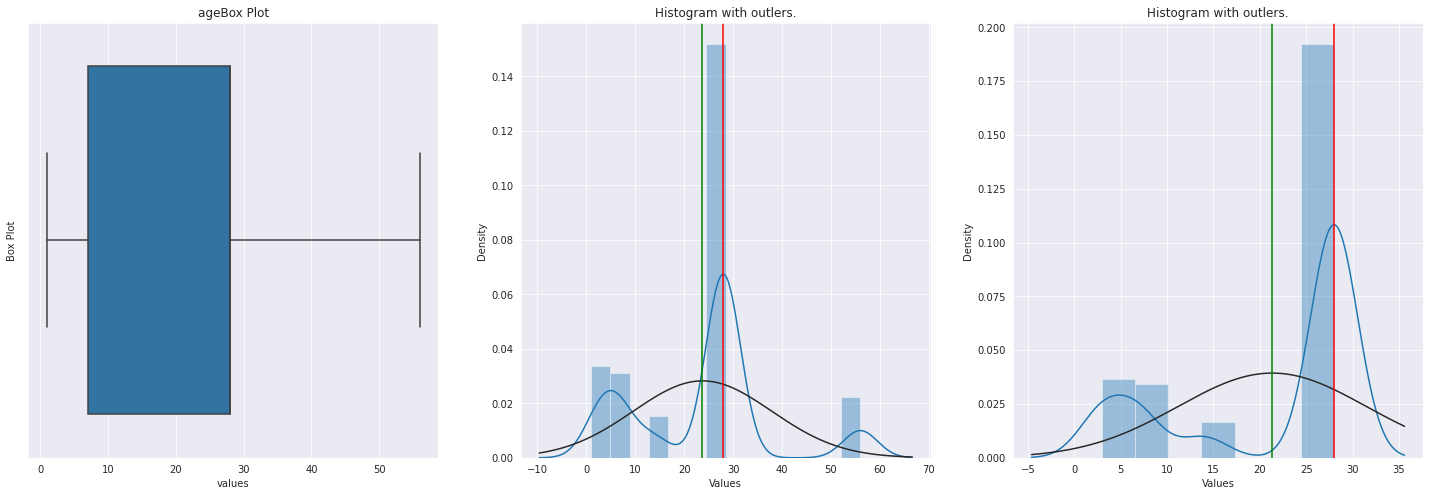

In [12]:
odt_plots(df, 'age')

Feature cement has outliers.

Total outliers in cement are 248.

Outlier percentage in cement is 24%.



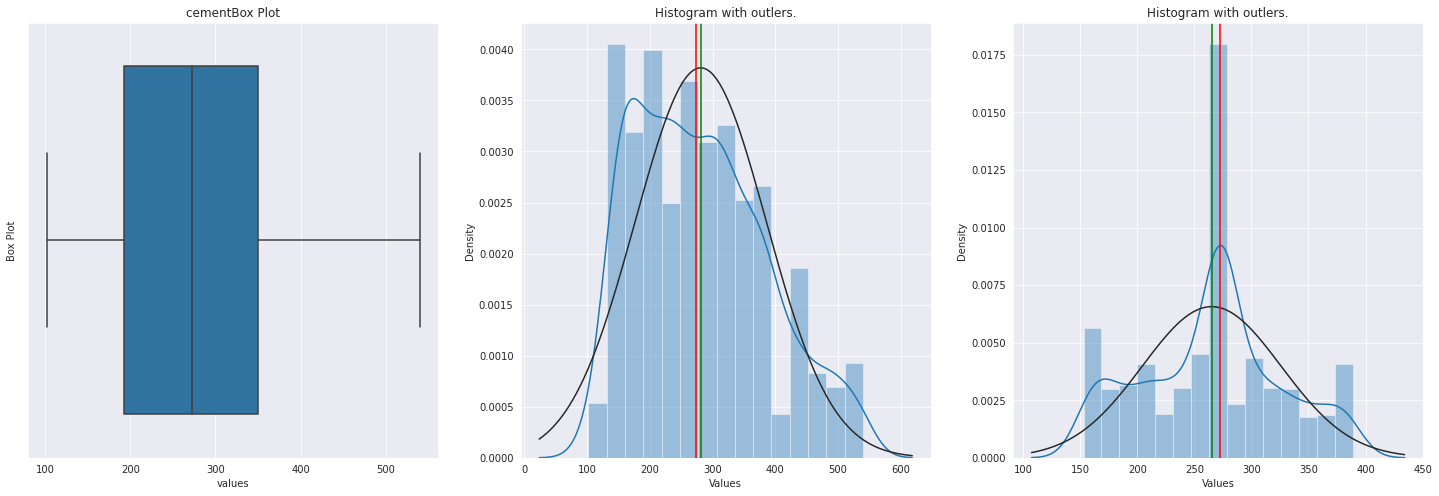

Feature slag has outliers.

Total outliers in slag are 169.

Outlier percentage in slag is 16%.



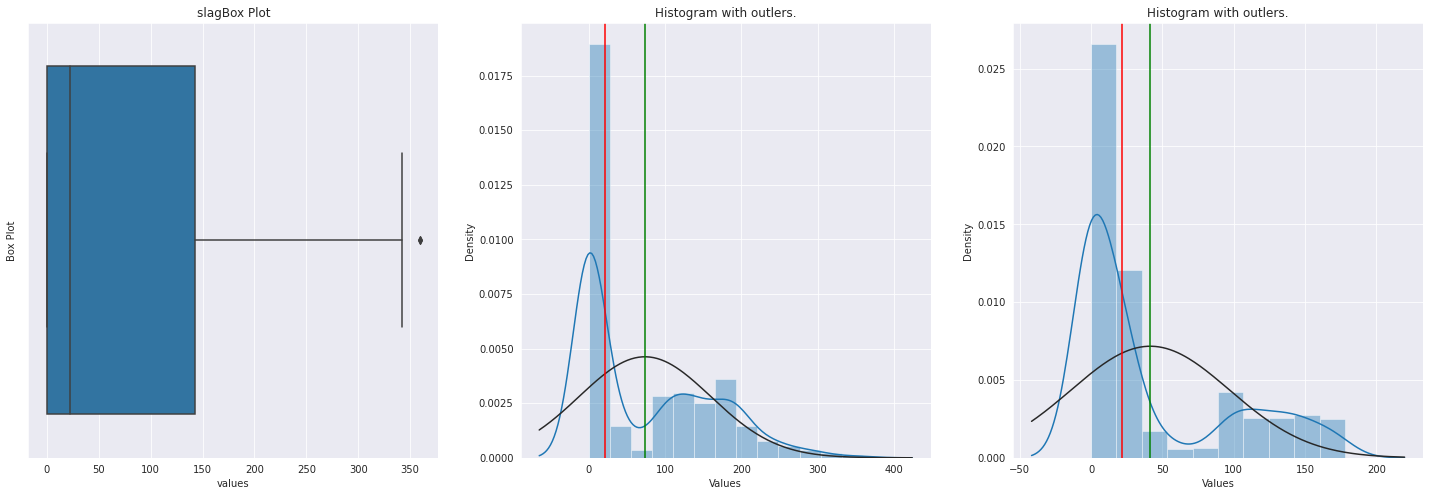

Feature ash has outliers.

Total outliers in ash are 86.

Outlier percentage in ash is 8%.



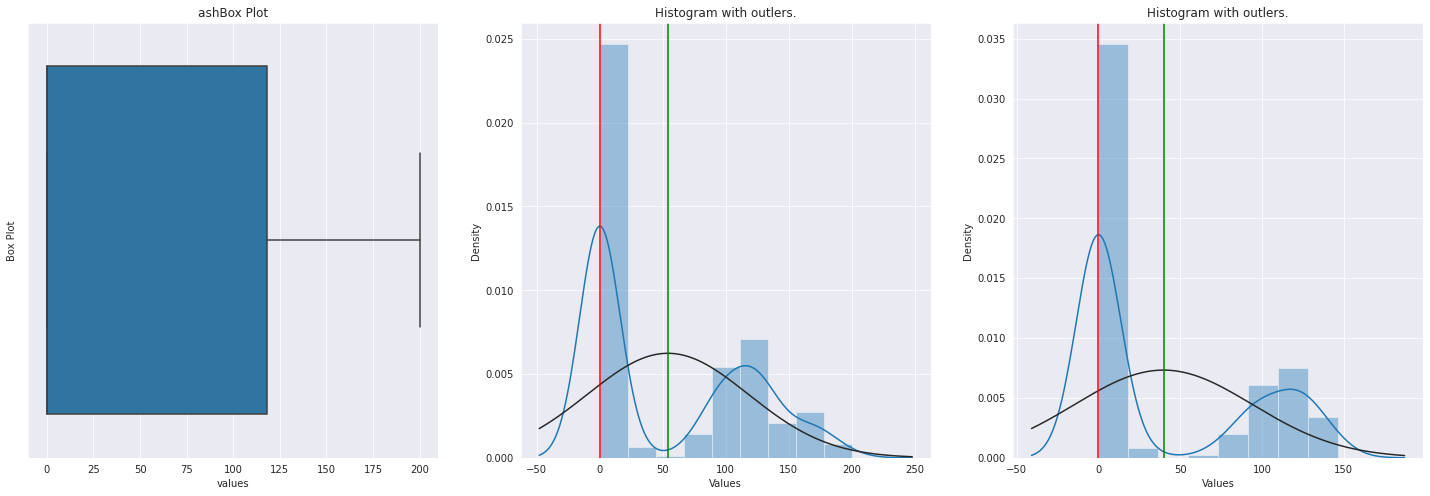

Feature water has outliers.

Total outliers in water are 326.

Outlier percentage in water is 32%.



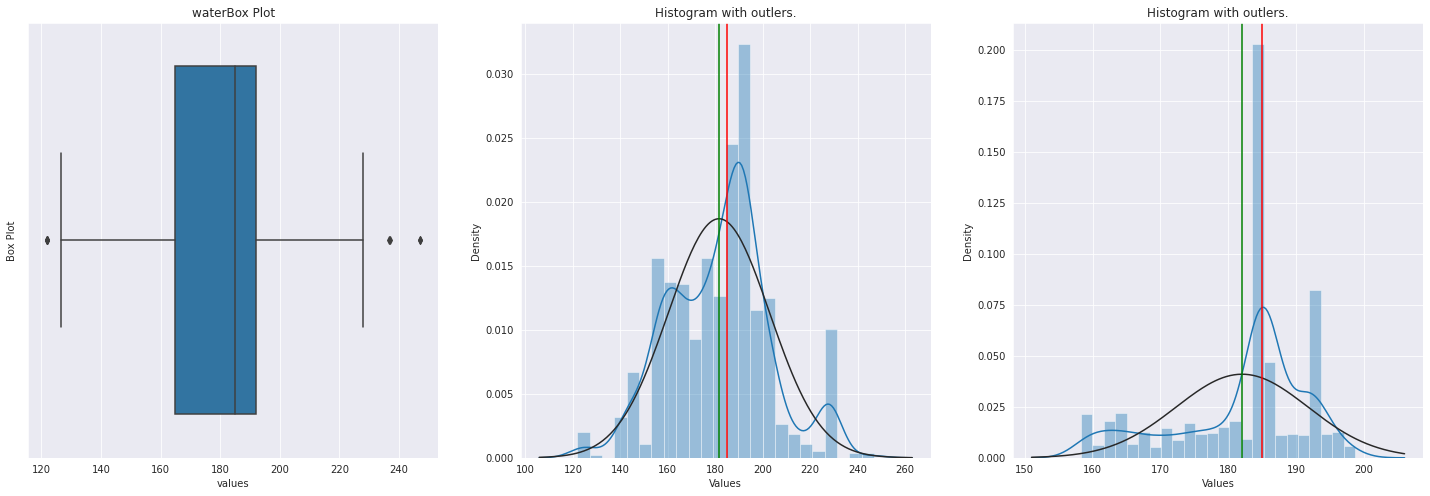

Feature superplastic has outliers.

Total outliers in superplastic are 94.

Outlier percentage in superplastic is 9%.



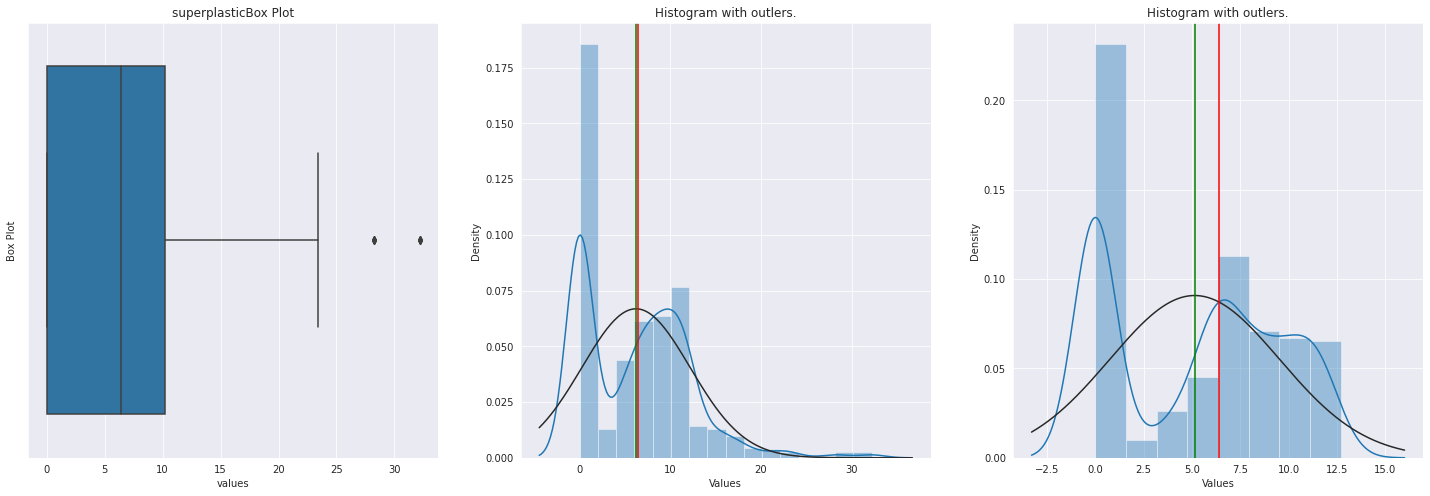

Feature coarseagg has outliers.

Total outliers in coarseagg are 374.

Outlier percentage in coarseagg is 36%.



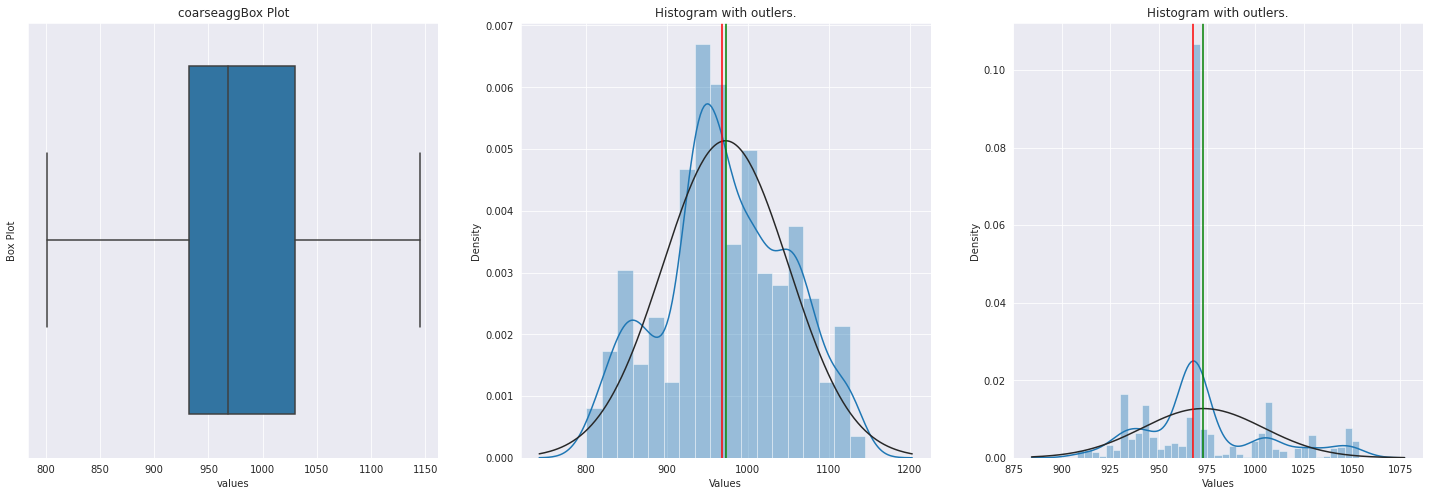

Feature fineagg has outliers.

Total outliers in fineagg are 388.

Outlier percentage in fineagg is 38%.



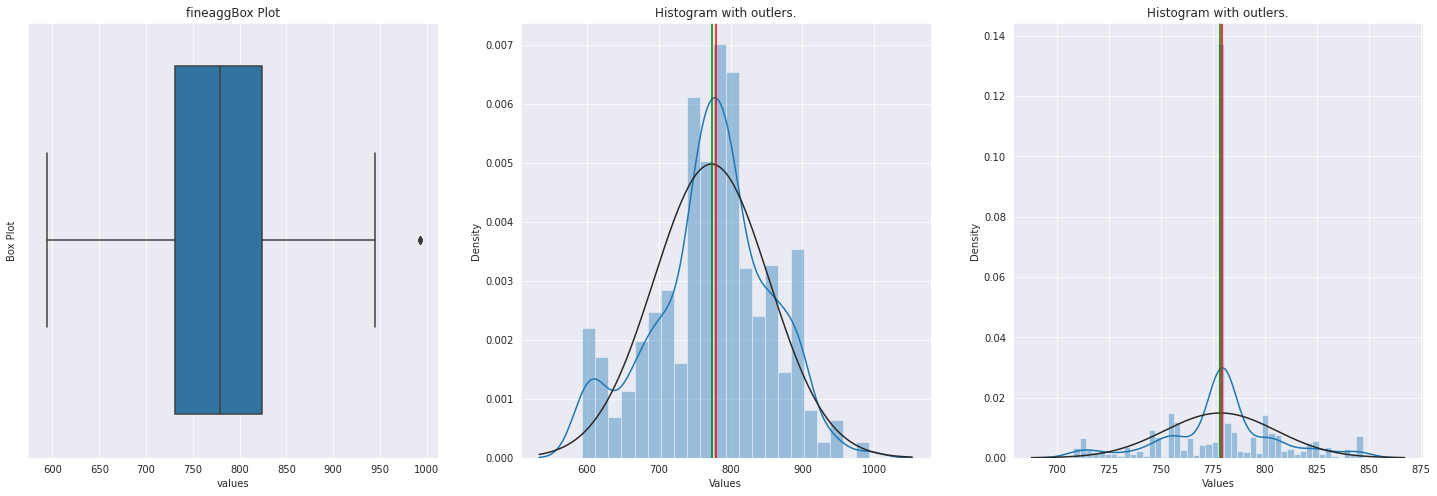

Feature age doesn't has any outliers.



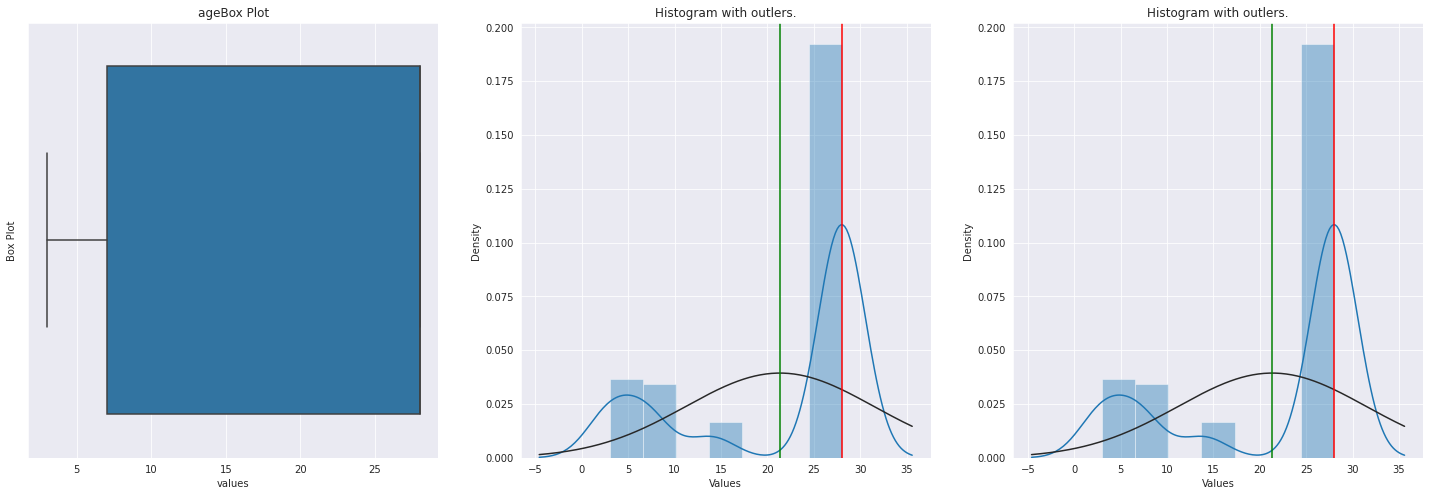

Feature strength has outliers.

Total outliers in strength are 360.

Outlier percentage in strength is 35%.



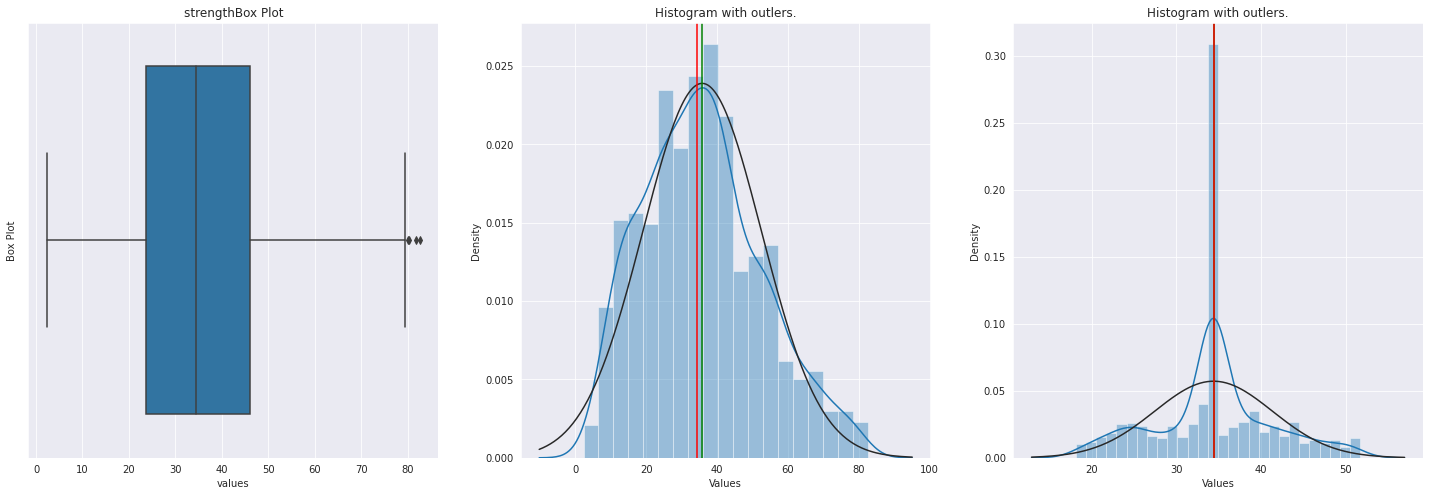

In [13]:
for col in df.columns:
  odt_plots(df,col)

**Multivariate Analysis using Regression**

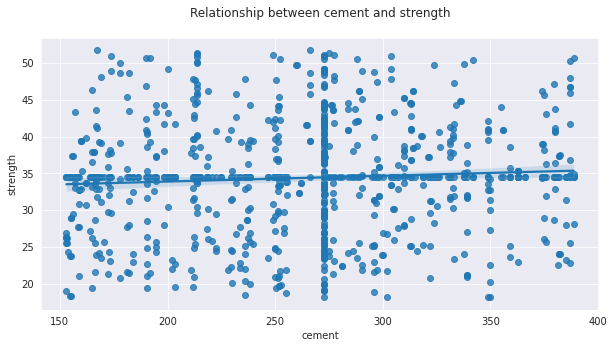

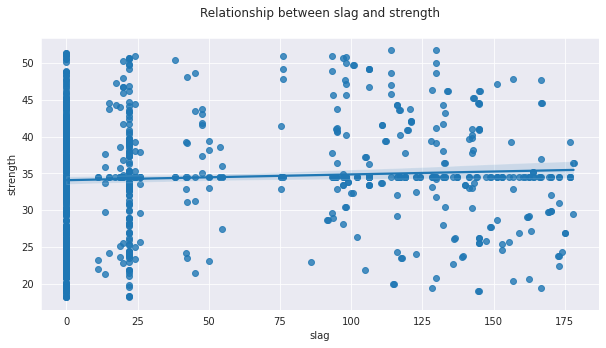

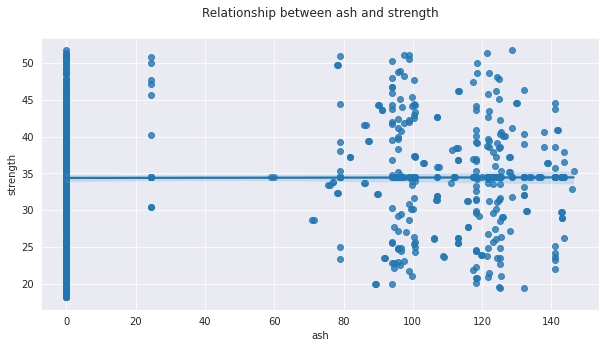

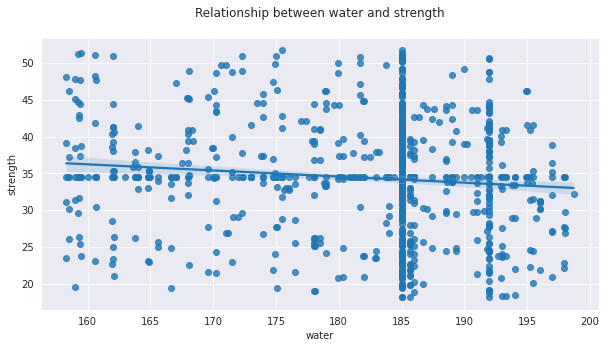

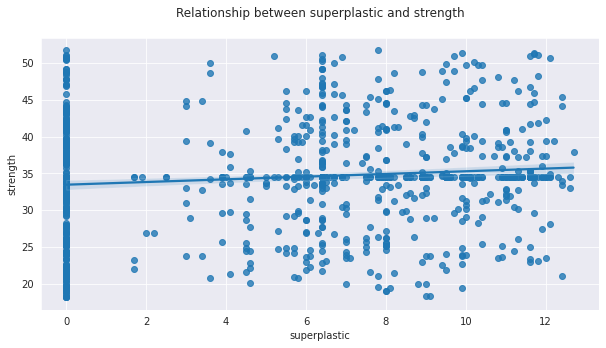

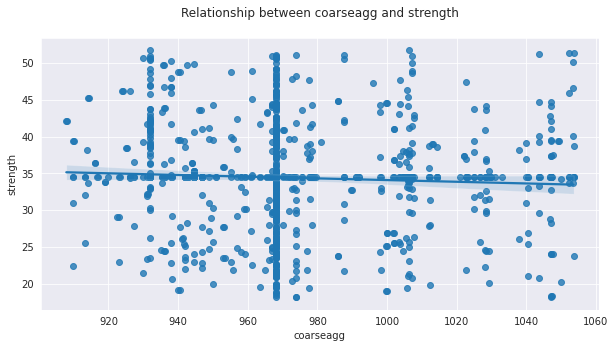

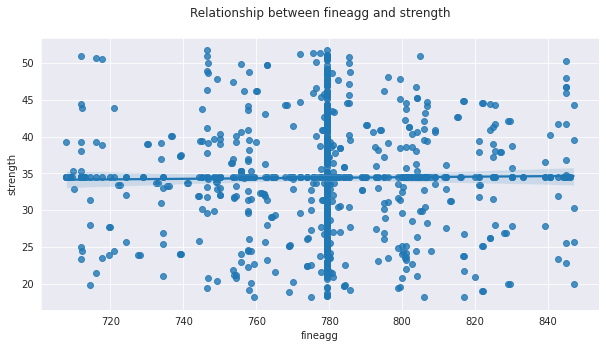

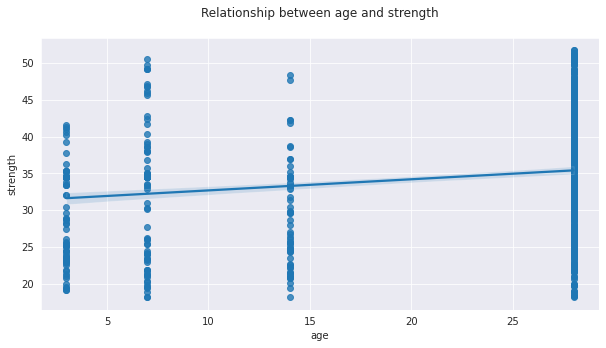

In [14]:
for col in df.columns:
  if col!='strength':
    fig,ax1 = plt.subplots(figsize=(10,5))
    sns.regplot(x=df[col], y=df['strength'], ax=ax1).set_title(f"Relationship between {col} and strength\n")

Analysis from regression plot:
+ Strength and cement are highly positively correlated.
+ Slag and strength are slightly positively correlated.
+ Ash and strength are sligthly negatively correlated.
+ Water and strength are highly negatively correlated.
+ Superplastic and strength are highly negatively correlated.
+ Coarseagg and strength are highly negatively correlated.
+ Fineagg and strength are highly negatively correlated.
+ Age and strength are highly positive correlated.

**Multi collinearity test**

+ Heatmap

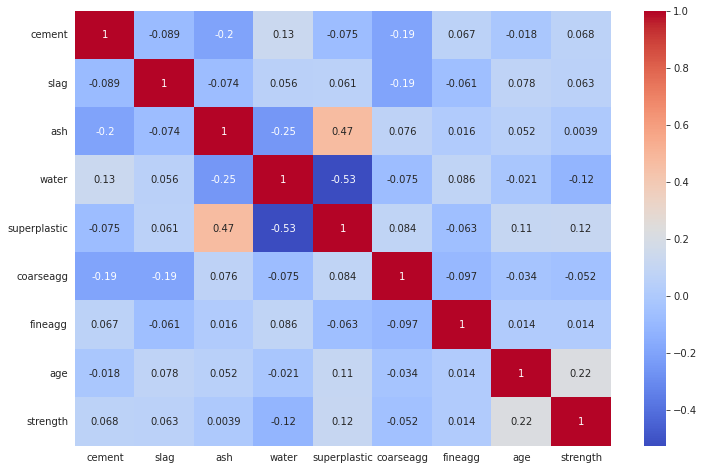

In [15]:
corr = df.corr()
df.ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Analysis from stage1 test (from mentor's notebook)
+ Cement has high correlation with strength.
+ slag has high correlation with ash.
+ ash has high correlation with cement.

---

+ VIF(variance inflation factor)

---

**Correlation with target feature**

In [16]:
def correlation_with_target(data, t_col):
  independent_variable = data.drop(t_col, axis=1).columns
  corr_result = []
  for col in independent_variable:
    corr_result.append(data[t_col].corr(data[col]))

  result = pd.DataFrame([independent_variable, corr_result], index=['Independent variables', 'Correlation']).T
  return result.sort_values('Correlation', ascending=False)

In [17]:
correlation_with_target(df, 'strength')

,Independent variables,Correlation
7,age,0.21969
4,superplastic,0.115053
0,cement,0.068042
1,slag,0.062584
6,fineagg,0.014087
2,ash,0.003939
5,coarseagg,-0.051786
3,water,-0.115852


**Applying PCA to treat multi-collinearity**

In [18]:
def custom_pca(X):
  n_comp = len(X.columns)

  #applying standard scaler for feature scaling
  sc = StandardScaler()
  X = sc.fit_transform(X)

  for i in range(1,n_comp):
    pca = PCA(n_components = i)
    p_comp = pca.fit_transform(X)
    evr = np.cumsum(pca.explained_variance_ratio_)

    if evr[i-1] > 0.9:
      pcs = i
      break
  print("Explained variance ratio after PCA is: ", evr)

  #Creating dataframe of Principal components
  col = []
  for j in range(1,pcs+1):
    col.append("PC_"+str(j))

  pca_df = pd.DataFrame(p_comp, columns=col)

  return pca_df

In [19]:
pca_df = custom_pca(df.drop('strength', axis=1))

Explained variance ratio after PCA is:  [0.24502475 0.39911617 0.53870788 0.66235781 0.7791632  0.86988265
 0.9550787 ]


+ We are able to retain 92.4% information
+ After applying standard scaling, we are able to retain 95.5% information.

In [20]:
pca_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
0,-1.049217,-0.310303,0.781544,0.227778,-1.156420,-0.339361,-0.614249
1,3.046600,0.061291,-0.369670,-0.065854,1.639539,0.455440,-0.980834
2,0.328088,0.123213,-0.473753,-0.702851,-0.284712,-1.292679,-0.259500
3,-1.452514,1.578413,0.763974,-0.207632,0.090703,0.073698,-0.534661
4,0.597768,-1.666135,1.392570,-1.785977,-0.605731,0.694457,0.651665


**Joining PCA features with target features**

In [21]:
pca_df = pca_df.join(df['strength'], how='left')  #using left join
pca_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,strength
0,-1.049217,-0.310303,0.781544,0.227778,-1.156420,-0.339361,-0.614249,29.89
1,3.046600,0.061291,-0.369670,-0.065854,1.639539,0.455440,-0.980834,23.51
2,0.328088,0.123213,-0.473753,-0.702851,-0.284712,-1.292679,-0.259500,29.22
3,-1.452514,1.578413,0.763974,-0.207632,0.090703,0.073698,-0.534661,45.85
4,0.597768,-1.666135,1.392570,-1.785977,-0.605731,0.694457,0.651665,18.29


In [22]:
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PC_1      1030 non-null   float64
 1   PC_2      1030 non-null   float64
 2   PC_3      1030 non-null   float64
 3   PC_4      1030 non-null   float64
 4   PC_5      1030 non-null   float64
 5   PC_6      1030 non-null   float64
 6   PC_7      1030 non-null   float64
 7   strength  1030 non-null   float64
dtypes: float64(8)
memory usage: 64.5 KB


**Model Building**

Stages of model building:
+ Custom train test split function
+ Cross-validation
+ Hyperparameter tuning

In [23]:
def tt_split(data, tcol, testsize=0.33, state=42):       #tcol = target col
  X = data.drop(tcol, axis=1)
  y = data[tcol]
  return train_test_split(X,y,test_size=testsize, random_state=state)

In [24]:
def model_builder(model_name, model, data, t_col):
  X_train, X_test, y_train, y_test = tt_split(data, t_col)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))

  result = [model_name, rmse, r2]
  return result

In [25]:
model_builder(model_name="Linear Regression", model = LinearRegression(), data=pca_df, t_col='strength')

['Linear Regression', 6.651541470873208, 0.082685552132302]

In [26]:
m = {
     'LinearRegression' : LinearRegression(),
     'Lasso' : Lasso(),
     'Ridge' : Ridge(),
     'DecisionTree' : DecisionTreeRegressor(),
     'KNN': KNeighborsRegressor(),
     'SVM' : SVR(),
     'RandomForest' : RandomForestRegressor(),
     'AdaBoost' : AdaBoostRegressor(),
     'GradientBoost' : GradientBoostingRegressor(),
     'XGBoost' : XGBRegressor(objective ='reg:linear', verbosity = 0, random_state=42)
  }

In [27]:
def multiple_models(data, t_col):
  col_names = ['Model Name', 'RMSE', 'R2 Score']
  result = pd.DataFrame(columns = col_names)

  for keys,values in m.items():
    result.loc[len(result)] = model_builder(keys, values, data, t_col)

  return result.sort_values('R2 Score', ascending=False)

In [28]:
model_df = multiple_models(pca_df, 'strength')
model_df

,Model Name,RMSE,R2 Score
6,RandomForest,5.964915,0.262296
9,XGBoost,6.254103,0.189032
8,GradientBoost,6.345988,0.165028
7,AdaBoost,6.355835,0.162434
0,LinearRegression,6.651541,0.082686
2,Ridge,6.651647,0.082656
5,SVM,6.767383,0.050456
4,KNN,6.834898,0.031415
1,Lasso,6.920364,0.007041
3,DecisionTree,7.690020,-0.226108


In [29]:
def k_fold_cv(X, y, fold=5):
  score = pd.DataFrame(columns = ['Model Name', 'CVMean', 'CVStd'])
  for keys,values in m.items():
    temp = cross_val_score(values, X, y, cv=fold)
    temp_mean = np.mean(temp)
    temp_std = np.std(temp)
    score.loc[len(score)] = [keys, temp_mean, temp_std]
  
  return score

In [30]:
cv_df = k_fold_cv(pca_df.drop('strength', axis=1), pca_df['strength'])

In [31]:
model_df = pd.merge(model_df, cv_df, left_on='Model Name', right_on='Model Name', how='left')

In [32]:
model_df

,Model Name,RMSE,R2 Score,CVMean,CVStd
0,RandomForest,5.964915,0.262296,0.187936,0.021663
1,XGBoost,6.254103,0.189032,0.163230,0.020399
2,GradientBoost,6.345988,0.165028,0.148324,0.027048
3,AdaBoost,6.355835,0.162434,0.112925,0.056288
4,LinearRegression,6.651541,0.082686,0.056354,0.037236
5,Ridge,6.651647,0.082656,0.056357,0.037200
6,SVM,6.767383,0.050456,0.044163,0.014536
7,KNN,6.834898,0.031415,0.092047,0.037852
8,Lasso,6.920364,0.007041,0.004366,0.011240
9,DecisionTree,7.690020,-0.226108,-0.180495,0.115437
